In [1]:
# Top level configuration options and convenience functions
ALLOW_ALL = False
ALLOWED_CATEGORIES = ["bicycling", "running", "walking"]
ALLOWED_JOINTS = [1, 4, 9, 12, 13] # r knee, l knee, head, r shoulder, l shoulder

import matplotlib.pyplot as plt
# show images
def show_image(img, gray: bool = False, annorect = None, scale = { "scale_height": 1, "scale_width": 1}):
    fig, ax = plt.subplots()
    if gray:
        plt.imshow(img, 'gray')
    else: 
        plt.imshow(img)
    for a in annorect:
        annopoints = a["annopoints"]
        x = [x["x"] * scale["scale_width"] for x in annopoints["point"]]
        y = [y["y"] * scale["scale_height"] for y in annopoints["point"]]
        plt.plot(x, y, "ro")
    plt.show()

def show_images(img1, img2, name1, name2, gray1: bool=False, gray2: bool=False, annorect = None, scale = { "scale_height": 1, "scale_width": 1}):
    fig, ax = plt.subplots(1, 2)

    fig.add_subplot(1, 2, 1)
    if gray1:
        plt.imshow(img1, 'gray')
    else:
        plt.imshow(img1)
    for a in annorect:
        annopoints = a["annopoints"]
        x = [x["x"] * scale["scale_width"] for x in annopoints["point"]]
        y = [y["y"] * scale["scale_height"] for y in annopoints["point"]]
        plt.plot(x, y, "ro")
    plt.title(name1)

    fig.add_subplot(1, 2, 2)
    if gray2:
        plt.imshow(img2, 'gray')
    else:
        plt.imshow(img2)
    for a in annorect:
        annopoints = a["annopoints"]
        x = [x["x"] * scale["scale_width"] for x in annopoints["point"]]
        y = [y["y"] * scale["scale_height"] for y in annopoints["point"]]
        plt.plot(x, y, "ro")
    plt.title(name2)

    plt.show()


In [2]:
from json import load
from pathlib import Path

# Load the annotation data
p = (Path().resolve() / "../pose_data/annotations.json").resolve()
annotations = load(p.open())

In [3]:
from tqdm.auto import tqdm

# Parse out the categories we care about
valid_imgs = []
for i in tqdm(range(len(annotations["act"]))):
    if ALLOW_ALL or annotations["act"][i]["cat_name"] in ALLOWED_CATEGORIES:
        valid_imgs.append(i)
print(f"Indexed {len(valid_imgs)} images with valid categories")

  0%|          | 0/24987 [00:00<?, ?it/s]

Indexed 1457 images with valid categories


In [4]:
from pprint import pp

# Make sure all of the images have annopoints
annorect_imgs = []

for i in tqdm(range(len(valid_imgs))):
    i_img = valid_imgs[i]
    annolist = annotations["annolist"][i_img]
    annorects = annolist["annorect"]
    if isinstance(annorects, dict): # Only one annorect, put it in a list to make it simpler to parse everything the same
        annorects = [annorects]
    valid_annorects = []
    for a in annorects:
        if "annopoints" in a.keys():
            if isinstance(a["annopoints"], list):
                if len(a["annopoints"]) > 0:
                    valid_annorects.append(a)
            else:
                valid_annorects.append(a)
    if len(valid_annorects) > 0:
        annorect_imgs.append({"id": i_img, "annorect": valid_annorects})

print(f"Indexed {len(annorect_imgs)} images with valid annorects")

  0%|          | 0/1457 [00:00<?, ?it/s]

Indexed 1385 images with valid annorects


In [5]:
import cv2
import numpy as np

images = []

# Load the images into memory

for i in tqdm(range(len(annorect_imgs))):
    image_name = annotations["annolist"][annorect_imgs[i]["id"]]["image"]["name"]
    real_path = (Path().resolve() / "../pose_data/images/images/" / image_name).resolve()
    img = cv2.imread(real_path.as_posix())
    if img is not None:
        images.append(
                {
                    "id": annorect_imgs[i]["id"],
                    "image": cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                    "annorect": annorect_imgs[i]["annorect"]
                }
            )

print(f"Indexed {len(images)} images for train/test")

  0%|          | 0/1385 [00:00<?, ?it/s]

Indexed 1385 images for train/test


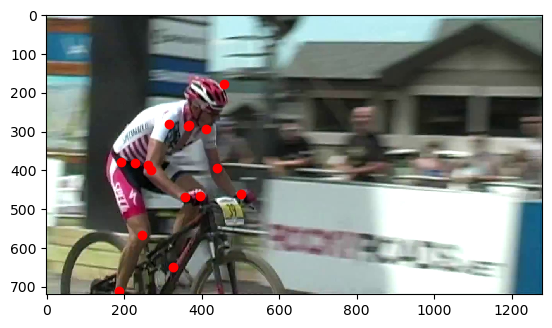

In [6]:
# Show a random image from the data
ind = np.random.randint(0, len(images))
show_image(images[ind]["image"], False, images[ind]["annorect"])

In [7]:
# Reduce the annorects to just the points we care about for our model
for i in tqdm(range(len(images))):
    annorects = images[i]["annorect"]
    for a in annorects:
        annopoints = a["annopoints"]
        if isinstance(annopoints, list):
            pp(annopoints)
            continue
        point = annopoints["point"]
        annopoints["point"] = [p for p in point if p["id"] in ALLOWED_JOINTS]

  0%|          | 0/1385 [00:00<?, ?it/s]

In [8]:
# Find the smallest image
height, width, depth = images[0]["image"].shape
for i in range(len(images)):
    h_i, w_i, d_i = images[i]["image"].shape
    if h_i < height:
        height = h_i
    if w_i < width:
        width = w_i

print(f"Smallest dimensions {height} x {width}")

Smallest dimensions 432 x 600


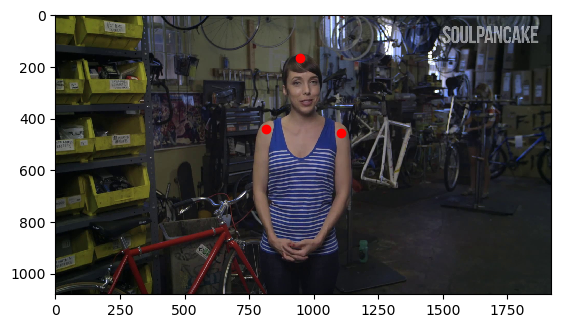

  0%|          | 0/1385 [00:00<?, ?it/s]

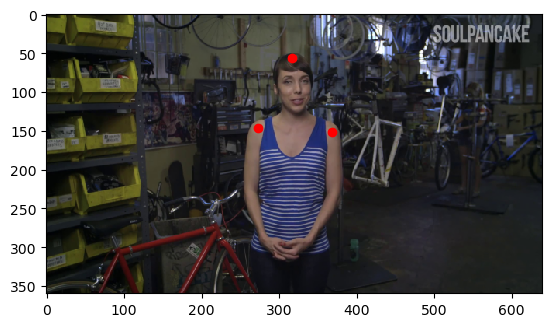

In [9]:
# Resize the images
from skimage.transform import resize

pre_scale = images[0]["image"]
show_image(pre_scale, False, images[0]["annorect"])
RESIZE_HEIGHT = 360
RESIZE_WIDTH = 640
for i in tqdm(range(len(images))):
    images[i]["scale_height"] = RESIZE_HEIGHT / images[i]["image"].shape[0] 
    images[i]["scale_width"] = RESIZE_WIDTH / images[i]["image"].shape[1]
    images[i]["image"] = resize(images[i]["image"], (RESIZE_HEIGHT, RESIZE_WIDTH))
show_image(images[0]["image"], False, images[0]["annorect"], {"scale_height": images[0]["scale_height"], "scale_width": images[0]["scale_width"]})

In [10]:
# # Make all of the images greyscale
# from skimage.color import rgb2gray

# pre_grey = images[1]["image"]
# for i in tqdm(range(len(images))):
#     images[i]["image"] = rgb2gray(images[i]["image"])
# show_images(pre_grey, images[1]["image"], "Original", "Greyscale", False, True, images[1]["annorect"], {"scale_height": images[1]["scale_height"], "scale_width": images[1]["scale_width"]})

In [11]:
# Make sure image values are [0, 1] instead of [0, 255]
print(np.max(images[0]["image"]))
print(np.min(images[0]["image"]))

0.9999781190829258
3.617645187625229e-05


In [12]:
# Split the data

TRAIN_SPLIT = int(np.floor(0.9 * len(images)))

train = images[:TRAIN_SPLIT]
test = images[TRAIN_SPLIT:]

x_train = [i["image"] for i in train]
y_train = [i["annorect"] for i in train]

x_test = [i["image"] for i in test]
y_test = [i["annorect"] for i in test]

In [13]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Create the model

inputs = keras.Input(shape=(RESIZE_HEIGHT, RESIZE_WIDTH, 3))

head = layers.Conv2D(filters=32, kernel_size=2, padding="same", activation="relu")(inputs)
head = layers.MaxPool2D(pool_size=2, strides=2)(head)
head = layers.Conv2D(filters=32, kernel_size=2, padding="same", activation="relu")(head)
head = layers.MaxPool2D(pool_size=2, strides=2)(head)
head = layers.Conv2D(filters=32, kernel_size=2, padding="same", activation="relu")(head)
head = layers.MaxPool2D(pool_size=2, strides=2)(head)
head = layers.Conv2D(filters=32, kernel_size=2, padding="same", activation="relu")(head)
head = layers.GlobalMaxPool2D()(head)
outputs = layers.Dense(2, activation="softmax")(head)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


2022-12-12 04:07:54.285101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 04:08:12.535919: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64
2022-12-12 04:08:12.536369: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64
2022-12-12 04:08:12.536401: W tensorflow/compiler/tf2tensorrt/utils/py_u

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 640, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 360, 640, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 320, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 320, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 160, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 160, 32)       4128  

In [14]:
# For now, just grab out the head information
x_train_filtered = []
y_train_filtered = []
for idx, y in enumerate(y_train):
    p = [(p["x"] * train[idx]["scale_width"], p["y"] * train[idx]["scale_height"]) for p in y[0]["annopoints"]["point"] if p["id"] == 9]
    if (len(p) > 0):
        y_train_filtered.append(p[0])
        x_train_filtered.append(x_train[idx])

x_test_filtered = []
y_test_filtered = []
for idx, y in enumerate(y_test):
    p = [(p["x"] * test[idx]["scale_width"], p["y"] * test[idx]["scale_height"]) for p in y[0]["annopoints"]["point"] if p["id"] == 9]
    if (len(p) > 0):
        y_test_filtered.append(p[0])
        x_test_filtered.append(x_test[idx])


x_train_filtered = np.array(x_train_filtered)
y_train_filtered = np.array(y_train_filtered)
x_test_filtered = np.array(x_test_filtered)
y_test_filtered = np.array(y_test_filtered)

In [ ]:
# Train

model.compile(optimizer="adam", loss=keras.losses.hinge, metrics=["acc"])

model.fit(x_train_filtered, y_train_filtered, epochs=10)

In [ ]:
# Test

test_scores = model.evaluate(x_test_filtered, y_test_filtered)
pp(f"Test loss: {test_scores[0]}")
pp(f"Test accuracy: {test_scores[1]}")

: 

In [ ]:
# Visualize an output
def show_prediction(img, actual, prediction):
    fig, ax = plt.subplots()
    plt.imshow(img)
    plt.plot(actual[0], actual[1], "go")
    x = prediction[0] * RESIZE_WIDTH
    y = prediction[1] * RESIZE_HEIGHT
    pp(f"Prediction {x} x {y}")
    pp(f"Actual {actual[0]} x {actual[1]}")
    plt.plot(x, y, "ro")
    plt.show()

idx = np.random.randint(0, len(x_test_filtered))
img = x_test_filtered[idx]
prediction = model(np.expand_dims(img, axis=0))



show_prediction(img, y_test_filtered[idx], np.array(prediction)[0])

: 